In [1]:
import os

import torch
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

import torchvision.models as models 
import torch.nn as nn

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data_path = '/content/gdrive/My Drive/ao_prediction/data/data_solar_mixed_2_100x100.pickle'


In [5]:

IMG_SIZE = 64
IMG_NUM = 10000

def batch_normalize(imgs):
  return (imgs - np.min(imgs))/(np.max(imgs) - np.min(imgs))

def point_normalize(imgs):
  new_imgs = []
  for img in imgs:
    new_img =  batch_normalize(img)
    new_imgs.append(new_img)
  return np.asarray(new_imgs)


def preprocessing(X, Y, Y_sumphase, outputs = 2, norm_type = (0, 0)):
   # нормировка и изменение размера
    X= np.asarray(X)
    Y= np.asarray(Y)

    if norm_type[0] == 1:
      X =  batch_normalize(X)
    else:
      X =  point_normalize(X)

    if norm_type[1] == 1:
      Y_sumphase =  batch_normalize(Y_sumphase)
    else:
      Y_sumphase =  point_normalize(Y_sumphase)
    print(X.shape)
    X_ = X.reshape(-1, outputs, IMG_SIZE,IMG_SIZE)
    Y_sumphase_ = Y_sumphase.reshape(-1,1,IMG_SIZE,IMG_SIZE)
    Y_ = Y
    X_train = torch.from_numpy(X_).float()
    y_train = torch.from_numpy(Y_).float()
    Y_sumphase_fin = torch.from_numpy(Y_sumphase_).float()
    return X_train, y_train, Y_sumphase_fin

def filter_good_idx(X):
  # отбираем только с хорошим индексом
  good_indx = []
  for i,x in enumerate(X):
    if np.sum(np.isnan(x))==0:
      good_indx.append(i)
  return good_indx

def get_traintest_data(path, outputs = 2, proportion = (0.9, 0.1, 0)):
  # получаем выборку
  with open(path, 'rb') as f:
      img1, img2, sum_phase, coeffs = pickle.load(f)

  img1 = img1.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
  img2 = img2.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
  #print(img1.shape, " 4")
  if outputs == 2:
    X = np.append(img1, img2, axis = 1)
    #print(X.shape)
  else:
    X = img1
    print(X.shape)
  y_coeffs = coeffs[:IMG_NUM]
  y_sum_phase = sum_phase[:IMG_NUM]
  X = X[:IMG_NUM]

  train_num, val_num, test_num = (int(IMG_NUM*proportion[0]),
                                  int(IMG_NUM*proportion[1]),
                                  int(IMG_NUM*proportion[2]))
  good_indx = filter_good_idx(y_coeffs)
  np.random.shuffle(good_indx)
  print(good_indx)
  X_train, y_train, y_train_sumphase =preprocessing(X[good_indx][:train_num], 
                                  y_coeffs[good_indx][:train_num], 
                                  y_sum_phase[good_indx][:train_num],
                                  outputs)

  X_val, y_val, y_val_sumphase =preprocessing(X[good_indx][train_num:train_num+val_num],
                              y_coeffs[good_indx][train_num:train_num+val_num], 
                              y_sum_phase[good_indx][train_num:train_num+val_num], 
                              outputs)
  if test_num!=0:
    X_test, y_test, y_test_sumphase =preprocessing(X[good_indx][train_num+val_num:train_num+val_num+test_num],
                              y_coeffs[good_indx][train_num+val_num:train_num+val_num+test_num],
                              y_sum_phase[good_indx][train_num:train_num+val_num], 
                               outputs)
    return (X_train, y_train, y_train_sumphase,
            X_val, y_val, y_val_sumphase,
            X_test, y_test,y_test_sumphase)

  return (X_train, y_train,y_train_sumphase,
          X_val, y_val, y_val_sumphase)

In [6]:
import pickle
X_train, _, y_train, X_val,_, y_val = get_traintest_data(data_path, outputs = 2)

[6629, 1221, 5041, 2993, 5096, 2920, 9569, 9219, 2598, 8103, 9945, 7558, 8858, 9382, 1897, 2194, 6116, 2430, 1412, 8679, 2954, 9345, 5657, 9560, 2582, 9501, 9225, 7424, 9805, 2434, 4290, 681, 4835, 4781, 2719, 8769, 9637, 2312, 5538, 4649, 218, 456, 6877, 8333, 7757, 2616, 1658, 2289, 2138, 8789, 3336, 1494, 8320, 591, 7667, 5649, 1211, 7043, 9689, 8154, 9741, 3452, 1328, 1534, 3090, 538, 5057, 463, 2620, 1486, 988, 9395, 3748, 1561, 2496, 1220, 8416, 999, 400, 6388, 4548, 2738, 1512, 7684, 3263, 8609, 9116, 8262, 8526, 7808, 150, 4470, 3092, 1941, 1784, 2320, 1098, 9578, 2956, 7905, 5365, 6793, 697, 5961, 1103, 6730, 2419, 6414, 5390, 5259, 2266, 6728, 7403, 4236, 7171, 9168, 3546, 552, 471, 6901, 6129, 5995, 2492, 8721, 7549, 5219, 1651, 98, 1580, 4877, 7172, 9721, 7542, 4194, 6090, 4259, 2309, 7303, 6910, 4062, 4769, 1136, 5877, 4263, 9464, 2259, 5031, 9565, 3036, 1241, 3680, 6873, 4786, 7277, 5710, 9879, 7640, 4838, 5224, 9458, 630, 4807, 3945, 3136, 3964, 8035, 7613, 6007, 3765, 7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


(9000, 2, 64, 64)
(1000, 2, 64, 64)


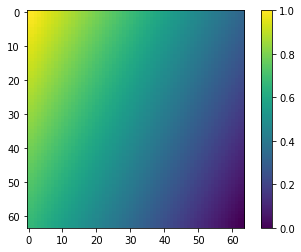

In [7]:
plt.imshow((y_train[4,0] - y_train[4,0].min())/( y_train[4,0].max()-  y_train[4,0].min()))
plt.colorbar()


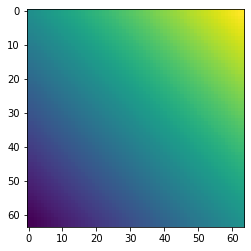

In [11]:
plt.imshow(y_train[45,0])

### Модель

In [ ]:
import torch.nn as nn

In [ ]:

import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False)


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [ ]:
model.encoder1 = nn.Sequential(
                      nn. Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.encoder2 = nn.Sequential(
                      nn. Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.encoder3 = nn.Sequential(
                      nn. Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.encoder4 = nn.Sequential(
                      nn. Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))


model.bottleneck = nn.Sequential(
                      nn. Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.decoder4 =  nn.Sequential(
                      nn. Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.decoder3 =  nn.Sequential(
                      nn. Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.decoder2 =  nn.Sequential(
                      nn. Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.decoder1 =  nn.Sequential(
                      nn. Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                      nn.ReLU(inplace=True),
                      nn. Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),                 
                      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                      nn.ReLU(inplace=True))

model.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
model.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
model.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
model.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))

model.conv = nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))

### Обучение


In [ ]:
!pip install wandb

     |████████████████████████████████| 1.6 MB 7.0 MB/s 
     |████████████████████████████████| 170 kB 71.4 MB/s 
     |████████████████████████████████| 133 kB 70.5 MB/s 
     |████████████████████████████████| 97 kB 10.3 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=bb5ad03fd7de763763dfd60ce099c2ee872b2df7f3bf9e62a4460e3b3aaa5a85
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=d81184cd0fe195136fe18b0a12cb50cdc285675608aacab7c529b9105fc0db46
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import wandb

In [ ]:
 loss_f = nn.MSELoss()
 optim = torch.optim.Adam(model.parameters(), lr=10**(-4))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = model.to(device)

In [ ]:
train_losses = []
val_losses = []
last_epoch = 0

In [ ]:
wandb.init(project='Unet_OneByOneNorm')

epoch,8
loss,0.06077
val-loss,0.18334
_runtime,513
_timestamp,1629380393
_step,7


epoch,▁▂▃▄▅▆▇█
loss,█▇▆▅▄▂▂▁
val-loss,▁▁▁▁▁▁▁▁
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


In [ ]:

it = 0
min_loss = np.inf
batch_size = 128
val_batch_size = 32
model.train()
for epoch in range(last_epoch,300):
      order = np.random.permutation(len(X_train))
      loss = 0.
      for start_index in range(0, len(X_train), batch_size):
          optim.zero_grad()
          batch_indexes = order[start_index:start_index+batch_size]
          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)

          preds = model.forward(X_batch)

          loss_value = torch.sqrt(loss_f(preds, y_batch))
          loss+=loss_value
          loss_value.backward()

          optim.step()
      if epoch%2 == 0:      
          order = np.random.permutation(len(X_val))
          val_loss = 0.
          for start_index in range(0, len(X_val), val_batch_size):
              optim.zero_grad()
              batch_indexes = order[start_index:start_index+val_batch_size]
              X_val_batch = X_val[batch_indexes].to(device)
              y_val_batch = y_val[batch_indexes].to(device)

              preds_val = model.forward(X_val_batch)

              loss_value_val = torch.sqrt(loss_f(preds_val, y_val_batch))
              val_loss+=loss_value_val
      coef_train =  len(X_train)/batch_size
      coef_val = len(X_val)/val_batch_size
      train_losses.append(loss/coef_train)
      val_losses.append(val_loss/coef_val )
      
      print("EPOCH - %d, train loss - %f, val loss - %f"%(epoch, loss/coef_train,val_loss/coef_val ))
      wandb.log({'epoch': epoch+1, 'loss': loss/coef_train,'val-loss': val_loss/coef_val})
      last_epoch = epoch

model.eval()
# val_loss = get_loss(val_dl, model)
# if val_loss < min_loss:
#     torch.save(model.state_dict(), bst_model_fpath)

EPOCH - 80, train loss - 0.009241, val loss - 0.008896


Exception: ignored

In [ ]:
predicted = preds_val[0][0].cpu().detach().numpy()
original = y_val_batch[0][0].cpu().detach().numpy()

In [ ]:
import datetime
model_name ="unet_resnet_%d_%d_%d_%d"%(datetime.datetime.now().day,
                                                  datetime.datetime.now().month,
                                                  datetime.datetime.now().hour,
                                                  datetime.datetime.now().minute)

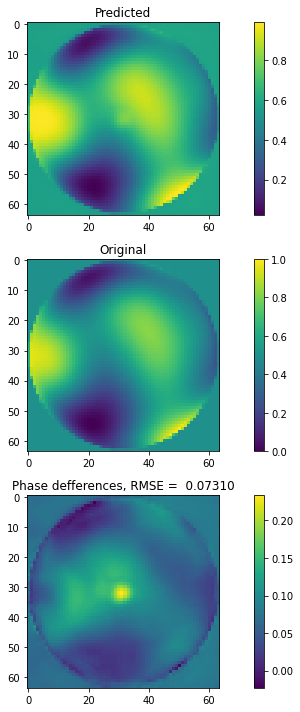

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.title("Predicted")
plt.imshow(predicted)
plt.colorbar()
plt.subplot(3,1,2)
plt.title("Original")
plt.imshow(original)
plt.colorbar()
plt.subplot(3,1,3)

plt.imshow(predicted-original)
loss_value = np.median((original -predicted )**2)**0.5
plt.title("Phase defferences, RMSE =  %.5f"%loss_value)
plt.colorbar()

plt.tight_layout()

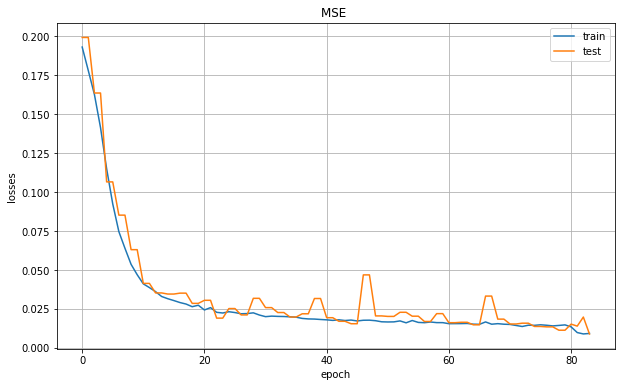

In [ ]:

check_file_hist = os.path.exists('/content/gdrive/My Drive/ao_prediction/history')

check_file_model = os.path.exists('/content/gdrive/My Drive/ao_prediction/model')

if not check_file_hist:
    os.mkdir("/content/gdrive/My Drive/ao_prediction/history")
if not check_file_model:
    os.mkdir("/content/gdrive/My Drive/ao_prediction/model")


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("losses")
plt.title("MSE ")


plt.savefig("/content/gdrive/My Drive/ao_prediction/history/%s.png"%model_name)
plt.legend()
plt.grid()
torch.save(model.state_dict(), "/content/gdrive/My Drive/ao_prediction/model/%s.torch"%model_name)


In [ ]:
data_path = '/content/gdrive/My Drive/ao_prediction/data/data_pointstar_mono2.pickle'
X_test, _, y_test, X_test,_, y_test = get_traintest_data(data_path, outputs = 2)

In [ ]:
order = np.random.permutation(len(X_test))
test_batch_size = 32
test_loss = 0.
for start_index in range(0, len(X_test), test_batch_size):
    optim.zero_grad()
    batch_indexes = order[start_index:start_index+test_batch_size]
    X_test_batch = X_test[batch_indexes].to(device)
    y_test_batch = y_test[batch_indexes].to(device)

    preds_test = resnet50.forward(X_test_batch)

    loss_value_test = torch.sqrt(loss_f(preds_test, y_test_batch))
    test_loss+=loss_value_test
coef_test = len(X_test)/test_batch_size
print(test_loss/coef_test)